# Spotify Genre Bridge
**Author:** Christopher Varghese

## Business Problem
Spotify is in the top tier of music streaming services. With over 100 million listeners, Spotify is always improving their platform to best serve their users. One of the main features of Spotify is their music reccomendation service. The provision of tailored picks ensures that users continue to stream music on their platform, and also benefits creators. Spotify's current algorithm reccomends songs that are similar in grouping and genre to the general pool of music that the user listens to. This model helps to improve their existing algorithm by providing a solution for providing song reccomendations from samples that are greatly differing in genre. Since a main function of music reccomendations are to constantly engage users, providing suggestions that bridge distinct genres that a user is fond of will likely provide the user with fresh music that appeals to their taste in both genres. Providing fresh music that is interesting to the user is a unique way to engage them beyond providing songs that adhere to a single genre that the user listens to, which may not be new music to the user. 

## Overview
This project finds paths between songs that are in different genres using playlist data which is user generated. In this project I will discuss:
- Data Acquistion and Treatment
- Visualization of the Data and Modelling Process
- Model Implementation
- Further Exploration

## Data Understanding
The data was retrieved from Spotify's Million Playlist Dataset Challenge. This dataset contains exactly 1 Million Playlist which were sampled from over 4 Billion playlists that exist on Spotify's Platform. This Dataset contains over 2 Million unique tracks by almost 300,000 artists. For the purposes of this model, I will be representing this data as an undirected weighted graph. In the graph, a node will be a single song and an edge will represent if two songs appear in a playlist together. The weight of each edge will denote the number of playlists the two songs appear in together. Here is an in-depth explanation on the graph data structure. https://www.geeksforgeeks.org/graph-data-structure-and-algorithms/

Since this dataset was generated by experts for the purpose of a competition, citing the creators is necessary. I have attached the citation here.

Spotify, Ching-Wei Chen, et al. “Recsys Challenge 2018: Automatic Music Playlist Continuation.” Recsys Challenge 2018 | Proceedings of the 12th ACM Conference on Recommender Systems, 1 Sept. 2018, dl.acm.org/doi/abs/10.1145/3240323.3240342. 

In [140]:
# Basic Imports
import json
import timeit
import heapq
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure

### Visualization of Data
The MPD is divided into 1,000 json files that each contain 1,000 playlists. In order to simply showcase and visualize the graph and search algorithms, 1,000 playlists is an adequate and managable sample. Since the graph and search algorithms are easily scalable in this implementation, utilizing 1,000,000 playlists will be simple to implement later. Additionally, these 1,000 playlists contain 29,005 unique tracks.

In [11]:
# Loading in Data
myfile = json.load(open('data/mpd.slice.316000-316999.json'))
myfile.keys()

dict_keys(['info', 'playlists'])

In [12]:
spdata = myfile['playlists']
len(spdata)

1000

In [13]:
spdata[0].keys()

dict_keys(['name', 'collaborative', 'pid', 'modified_at', 'num_tracks', 'num_albums', 'num_followers', 'tracks', 'num_edits', 'duration_ms', 'num_artists'])

In [122]:
# Quick Visualization of the first 5 Playlists
song_names = []
song_counts =[]
for playlist in spdata:
    for item in playlist['tracks']:
        song_name = item['track_name']
        if song_name not in song_names:
            song_names.append(song_name)
            song_counts.append(1)
        else:
            index = song_names.index(song_name)
            song_counts[index] += 1
            
len(song_counts)

29005

In [118]:
max(song_counts)

59

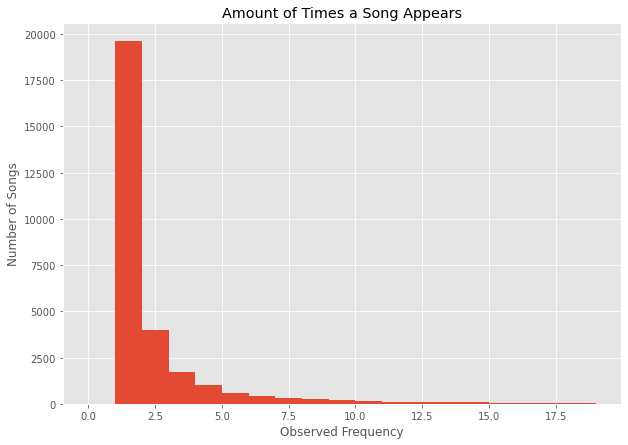

In [159]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(song_counts, bins = range(0, 20))
plt.ylabel('Number of Songs')
plt.xlabel('Observed Frequency')
plt.title('Amount of Times a Song Appears')
plt.savefig('pics/song_dist')
plt.show()

This visual shows the distribution for the frequencies of songs as they appear in the 1,000 playlists. The vast majority of songs only appear a single time in this data set. Alternatively, this distribution is heavily skewed to the right as there are even a minute amount of songs appearing more than 50 times. This means that the playlists are very connected, but they still contain enough sparse songs to provide new and valuable reccomendations with.

In [162]:
#spdata[:5]

### Modelling Process
Above is the json structure for the first five playlists in the data set. I will be representing the graph using an adjency list. This will be a dictionary where a key is a track and the value is a list of tuples containing connected songs and their corrosponding edge weights. An in depth explanation of graph representation and specifically adjency lists can be found here. https://www.geeksforgeeks.org/graph-and-its-representations/

In [18]:
# This is the main function that will assemble the adjency list
# from the json containing various playlists
# Param: json specifically formatted as seen in the MPD
def create_list(data):
    adjlist = {}
    # Iterate through each playlist
    for playlist in data:
        # Itemize each song in the playlist
        songs = []
        for item in playlist['tracks']:
            songs.append(item['track_name'])
        # Add edges between all songs in the playlists
        for song1 in songs:
            for song2 in songs:
                # Skip same case to avoid reflective edges
                if song1 == song2:
                    continue
                else:
                    add_edge(song1, song2, adjlist)
    return adjlist

# Helper functino for create_list function
# This can also be used manually to add edges if desired
# Param: String node1 - track name and outgoing edge
# String node2 - track name and incoming edge
# Dictionary adjlist - current adjency list
def add_edge(node1, node2, adjlist):
    # Basic check to prevent reflective edge
    if node1 == node2:
        return
    # Check to see if node1 is new to adjlist
    if node1 not in adjlist.keys():
        adjlist[node1] = []
    
    # bool to check if an edge is already present
    present = False
    # check each edge connected to node1
    for edge in adjlist[node1]:
        # if node2 is present, increase the weight by 1 and update bool
        if node2 == edge[0]:
            edge_weight = edge[1] + 1
            adjlist[node1].remove(edge)
            adjlist[node1].append((node2, edge_weight))
            present = True
            break
    # add the edge if it does not already exist
    if not present:
        adjlist[node1].append((node2, 1))

In [130]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [160]:
# This is a class for creating a graph visualization using networkx
# Credit: https://www.geeksforgeeks.org/visualize-graphs-in-python/
class GraphVisualization:
    def __init__(self):        
        # visual is a list which stores all 
        # the set of edges that constitutes a
        # graph
        self.visual = []
    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)       
    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.savefig('pics/graph')
        plt.show()

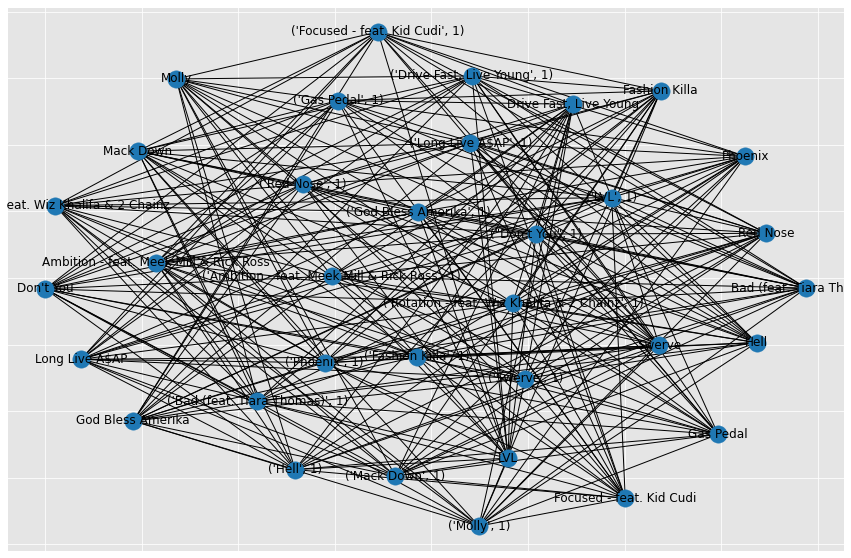

In [161]:
vis_list = create_list(spdata[:1])

G = GraphVisualization()
for song1 in vis_list.keys():
    for song2 in vis_list[song1]:
        G.addEdge(song1, song2)
fig, ax = plt.subplots(figsize =(15, 10))
G.visualize()

This is a visual representation of the graph structure. Of course, this is only a small sample of songs and it is already very cluttered since each song has an edge with every song that it is in a playlist with.

In [163]:
sp_adjlist = create_list(spdata)

In [164]:
#sp_adjlist.keys()

In [165]:
len(sp_adjlist.keys())

29005

### Model Implementation
Now that the adjency list is created and we have a list of all the songs that appear in these 1,000 playlists, we can begin implementing the model. For the first iteration of my model, I will be using a Breadth-First search. Out of the two basic search algorithms, DFS(Depth-First search) and BFS, I chose BFS for multiple reasons. First, BFS will yield the shortest distance between two nodes in a graph whereas DFS does not guarantee its output is the shortest path. Secondly, since this is such a well-connected and expansive graph, the runtime of searching children before neighboring nodes(DFS) will have a much higher runtime than starting at one point and searching all neighboring nodes first(BFS). The output of the BFS search will be a path of nodes from one song to another. The outputted path will likely contain songs that are relevant to both starting and ending songs since the path is a bridge between the two songs. This iteration of the model properly searches the graph but does not take advantage of the edge weights. A detailed explanation on BFS can be found here. https://www.geeksforgeeks.org/breadth-first-search-or-bfs-for-a-graph/

In [20]:
# bfs implemenation
def bfs(start, target, adjlist):
    # Initialize queue and visited list for BFS
    queue = []
    visited = []
    
    # Append starting point to both lists
    queue.append([start])
    visited.append(start)
    
    # While there are nodes that have not been searched
    while queue:
        # Pop the next node in the queue
        currpath = queue.pop(0)
        currnode = currpath[-1]
        # Check for target
        if currnode == target:
            return currpath
        # Add neighbors to the queue if they haven't been searched
        for edge in adjlist[currnode]:
            neighbor = edge[0]
            if neighbor not in visited:
                visited.append(neighbor)
                queue.append(currpath + [neighbor])
    # Confirm the two songs are not connected after all nodes are searched
    return 'no path exists'

In [41]:
# Test two songs that are in a playlist together
start = timeit.default_timer()
print(bfs('LVL', 'Hell', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

['LVL', 'Hell']
Time:  8.58146164380014


In [42]:
# Test two songs that are in the same genre but do not share a playlist
start = timeit.default_timer()
print(bfs('LVL', 'Rolex', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

['LVL', 'Panda', 'Rolex']
Time:  146.20019726175815


In [43]:
# Test two songs that are in totally different genres
start = timeit.default_timer()
print(bfs('LVL', 'The Wheels On the Bus', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

['LVL', 'Molly', 'Lean On (feat. MØ & DJ Snake)', 'The Wheels On the Bus']
Time:  729.4808174837381


After analyzing the paths for these test cases, the BFS model is able to show the shortest path between two songs. In order to improve the runtime of this model so that it scales better with larger data, the next iteration of this model will be an A* search. An A* search is an improvement on a regular search by implementing a path cost that will reduce the number of nodes explored before a solution is found. This will be attained by using the edge weights which have already been calculated. The algorithm will use a priority queue to pop nodes that have the lowest path cost. This lowest path cost, f(n), will be computed by adding distance from starting point, g(n), and the heuristic, h(n), which is the inverse of the currents node edge weight. This will always pop neighbors before children since h(n) is less than or equal to 1. In other words, f(n) <= g(n) + 1 for any given node. This guarantees that the path found will be the shortest path but nodes that are 'more connected' nodes will be popped first.

In [45]:
# A* implemenation
def astar(start, target, adjlist):
    # Initialize queue and visited list for A*
    queue = []
    visited = []
    
    # Append starting point to both lists
    # Also keep track of path cost(first input) and order which is a tiebreaker(second input)
    queue.append((0.0, 0, [start]))
    visited.append(start)
    
    order = 0
    
    # While there are nodes that have not been searched
    while queue:
        # Pop the next node in the queue with lowest path cost
        currinfo = heapq.heappop(queue)
        currpath = currinfo[2]
        currnode = currpath[-1]
        # Check for target
        if currnode == target:
            return currpath
        # Add neighbors to the queue if they haven't been searched
        for edge in adjlist[currnode]:
            neighbor = edge[0]
            if neighbor not in visited:
                visited.append(neighbor)
                # calculate path cost
                path_cost = 1 / edge[1]
                path_cost += len(currpath)
                # increment order
                order += 1
                heapq.heappush(queue, (path_cost, order, currpath + [neighbor]))
    # Confirm the two songs are not connected after all nodes are searched
    return 'no path exists'

In [46]:
# Test two songs that are in a playlist together
start = timeit.default_timer()
print(astar('LVL', 'Hell', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

['LVL', 'Hell']
Time:  0.03227363107725978


In [47]:
# Test two songs that are in the same genre but do not share a playlist
start = timeit.default_timer()
print(astar('LVL', 'Rolex', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

['LVL', "F**kin' Problems", 'Rolex']
Time:  132.59480552608147


In [48]:
# Test two songs that are in totally different genres
start = timeit.default_timer()
print(astar('LVL', 'The Wheels On the Bus', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

['LVL', 'Blessings', 'Watch Me (Whip / Nae Nae)', 'The Wheels On the Bus']
Time:  724.8669828400016


As expected, the A* search is marginally faster than the BFS search. One thing to note is that the paths for the last two tests are actually different. This means that there are multiple paths to certain songs that are the same path length. The difference between these results and the BFS search is that these paths are joined with edges that have the strongest connection. The next iteration of the model will be to actually calculate all the shortest paths and join them to a set so there are more songs to reccomend. Of course this can be easily modified to order the path results in terms of the most strongly connected paths to the least strongly connected paths. Since the next iteration of the model is looking for all the shortest paths, repeating the BFS exhaustively will suffice.

In [74]:
# bfs implemenation
def bfs_allpaths(start, target, adjlist):
    # Initialize queue and visited list for BFS
    queue = []
    visited = []
    allpaths = []
    
    # Append starting point to both lists
    queue.append([start])
    visited.append(start)
    
    # set up conditions for finding additional paths
    first_path_found = False
    max_pathlength = 0
    
    # While there are nodes that have not been searched
    while queue:
        # Pop the next node in the queue
        currpath = queue.pop(0)
        #print(currpath)
        if (first_path_found and (len(currpath) > max_pathlength)):
            break
            
        currnode = currpath[-1]
        # Check for target
        if currnode == target:
            #print('     OMG OMG found a solution!')
            allpaths.append(currpath)
            # set cap for path length since shortest path has been found
            first_path_found = True
            max_pathlength = len(currpath)
        # Add neighbors to the queue if they haven't been searched
        for edge in adjlist[currnode]:
            neighbor = edge[0]
            if neighbor not in visited:
                if neighbor != target:
                    visited.append(neighbor)
                queue.append(currpath + [neighbor])
    to_return = set()
    for path in allpaths:
        for song in path:
            to_return.add(song)
    return to_return
    # will return empty set if there is no path

In [75]:
# Test two songs that are in a playlist together
start = timeit.default_timer()
print(bfs_allpaths('LVL', 'Hell', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

{'LVL', 'Hell'}
Time:  10.38193807285279


In [76]:
# Test two songs that are in the same genre but do not share a playlist
start = timeit.default_timer()
print(bfs_allpaths('LVL', 'Rolex', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

{"Hold On, We're Going Home", 'One Night', 'Real Chill', 'Uber Everywhere', 'Too Good', 'Do What I Want', 'Or Nah (feat. The Weeknd, Wiz Khalifa and DJ Mustard) - Remix', 'Low Life', 'White Iverson', 'Go Flex', 'pick up the phone', 'Look Alive', 'Childs Play', 'Big Lie', 'This Could Be Us', 'Flexicution', 'Ride', 'Selfish', 'Down In the DM', 'Yours Truly, Austin Post', 'I Mean It', 'Rolex', 'LVL', 'Culture (feat. DJ Khaled)', 'Swimming Pools (Drank)', 'Make Me Proud', 'Jungle', 'I Fall Apart', 'Work', 'I Feel It Coming', 'You Was Right', 'One Dance', 'Congratulations', 'Mask Off', 'Feeling Whitney', 'T-Shirt', 'Panda', 'Young Prodigy', 'Gold Digger', 'OOOUUU', 'do re mi', 'Bounce Back', 'lose', 'L$D', 'Pop Style', 'Still Here', 'Chill Bill', 'Check', 'Jumpman', 'Legend', "F**kin' Problems", 'Fake Love', 'Wet Dreamz', 'Swang', 'Lockjaw', 'XO TOUR Llif3', '4 AM', 'Gassed Up', 'X (feat. Future)', 'Thought It Was a Drought', 'Caroline', 'No Option', 'Money Made Me Do It', 'Know Yourself', 

In [88]:
# Test two songs that are in totally different genres
start = timeit.default_timer()
print(bfs_allpaths('LVL', 'The Wheels On the Bus', sp_adjlist))
stop = timeit.default_timer()
print('Time: ', stop - start)

{'Everybody', 'LVL', 'Watch Me (Whip / Nae Nae)', 'I Just Can\'t Wait to Be King - From "The Lion King"/Soundtrack Version', 'Molly', 'Purple Haze', 'Under the Sea - From "The Little Mermaid"/ Soundtrack Version', 'The Wheels On the Bus', 'Ghostbusters', 'Let It Go - From "Frozen"/Soundtrack Version', 'This Is Halloween', 'Problem', 'Run This Town', 'Tuesday (feat. Drake)', 'Gas Pedal', 'Angels', 'New Slaves', 'Fly', 'All In', 'Runaway', 'Too Much', 'Digits', 'Danger Zone', 'Pokemon Theme', 'These Days', 'Lean On (feat. MØ & DJ Snake)', 'Everyday', 'Shake It Off', 'The Fox (What Does The Fox Say?)', 'When Can I See You Again?', 'ABC', 'V. 3005', 'Marvins Room', 'I Like To Move It', 'With You', 'Cake By The Ocean', 'Try Everything - From "Zootropolis"', 'Hakuna Matata', 'Ice Ice Baby'}
Time:  868.0594396949746


The results from the last model are very satisfactory. Through manual testing, I ensured that there was no shorter path than the paths listed above. As the songs increased in distance from one another, the runtime of searching all possible same-length shortest paths did not seem to increase tediously from the model that stopped after finding a single solution. The big advantage of this model is that if everything is working as intended, this is a great testing tool for more complex search algorithms that use a math-heavy heuristic function where it may not be as easy to test the results.

## Conclusion and Next Steps
The current final model is performing very well. It is able to accurately retrieve a list of relevant songs that bridges the differing genres of two songs. The clear next step is further testing of this model with the entirety of the MPD so that I can ensure that this model is working perfectly as intended. Once I am able to confirm that the BFS is working with 100% accuracy, I can use that algorithm to test further iterations of this model. Beyond this, I have a few more iterations that can be implemented easily based on the current performance of the model and will improve and bring new information. The first is to use an iteratively deeping DFS. This algorithm may be faster than the BFS since it is a hybrid of the BFS and DFS search algorithms. Another key element to add is the functionality to take multiple songs as an input. This would either require a 'greedy' search which will find a path through all the inputted songs quickly, or a comprehensive A* search that finds the exact shortest path.

While this model is extremely relevant to a service like spotify, and can provide a new angle for their song reccomendation algorithm, this has further applications in the music streaming realm and other business uses. Firstly, this algorithm which utilizes the connectedness of playlists to generate a list of reccomended songs can be used for group playlist creation. For example, a school may be trying to put together a playlist for their homecoming dance. This model can be tweaked to perform a most-connectedness search to give a playlist that takes into account all of the playlists submitted by students. Rather than simply tally up the most frequented songs and dump them into a playlist, this algorithm would ensure that majority of the students are actually contributing the group playlist while still containing the most popular songs overall. This model also has applications in social media networks, itemized transactions, route optimization and so forth. 

Contact me at

**Email:** chrisvarghese2000@gmail.com

**Phone:** 312-823-5252